## Police Stops in San Diego 2014-2017 Alogrithm Audit
> Dataset Source: https://openpolicing.stanford.edu/data/

##### David Aminifard  
##### A15451805  
##### Aaron Mcmillan Fraenkel  

# Recap & Transition

> In the prior report, "Police Stops in San Diego 2014-2017 Fairness Evalutation", we explored a police dataset to uncover whether it measures up in terms of Demographic Parity and Rawlsian Fair Equality of Opportunity. The context we provided at the beginning of the report strongly indicated that we should expect that Demographic Parity would not be met in regards to proportions of police searches and contraband being found, and it was not. To further validate our findings, we ran an A/B test to see if our findings were statistically significant, and they were. We concluded that police officers were more likely to wrongly search Blacks than Whites. In light of this, if we look at police officers as if they were classification algorithms (since they decide who to search), we have strong evidence that they have a higher failure rate for Blacks than Whites. This report will continue to analyze police officers in this manner.

> The procedure of this report will go as follows:
>    * We will create a simple machine learning algorithm that will predict whether an individual gets searched or not.
>    * We will use the algorithm to output the probabilities of someone getting searched. These probabilities will be preprocessed and used as a new feature.
        * This algorithm will basically be used for feature engineering.
>    * We will evaluate the fairness of the raw probabilities through intersectionality analysis
>    * We will use preprocessing techniques to improve the fairness of the probabilites.
>    * We will use the resulting (more fair) probabilites as a new feature for our second (final) algorithm.
>    * We will evalutate the fairness of the new algorithm through intersectionality analysis.

> I was not sure of a better way to create scores to rank individuals than using a classification algorithm to predict probabilities. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import warnings
import seaborn as sns
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
warnings.simplefilter("ignore")

In [2]:
enc = preprocessing.LabelEncoder()

In [3]:
def get_search_probs(df, metric):
    race_search = df[['subject_race', metric]]
    race_search[metric] = race_search[metric].apply(lambda x: 1 if x==True else 0)
    race_search_df = (race_search.groupby(['subject_race']))[metric].value_counts(normalize=True).rename('proportion').reset_index()
    race_search_df[metric] = race_search_df[metric].apply(lambda x: 'Searched' if x==1 else 'Not Searched')
    return race_search_df

In [4]:
df = pd.read_csv('ca_san_diego_2020_04_01.csv')
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['hour'] = pd.to_datetime(df['time']).dt.hour
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek
df['had_info'] = df['reason_for_stop'].apply(lambda x: 1 if ('info' in str(x).lower()) or 
                                             ('knowledge' in str(x).lower()) else 0)

In [5]:
features = ['hour', 
            #'subject_race', 
            #'subject_sex', 
            #'subject_age',
            'service_area',
            'day_of_week',
            'month',
            'had_info'
           ]
labels = ['search_conducted']

In [6]:
feature_df = df[features].apply(enc.fit_transform)
label_df = df[labels]

In [7]:
x_train, x_test, y_train, y_test = train_test_split(feature_df, label_df, test_size=0.25)

# Random Forest Classifier

> Using the sklearn package we are predicting whether someone will be searched based off factors that includes: the of the hour of the day, the service area (the location of the traffic stop), the month, day of the week, and whether the officer had prior info on the individual.

> The mean accuracy, i.e. score, of the classifier is rather high. There is a strong indication from the barcharts that this simple ML algorithm perpetuates a similar lack of demographic parity as the officers themselves do, as we covered before.

> While the algorithm yields less contraband (less True Positives), it also predicts less searches that result in no contraband (Less False Positives). Unsuprisingly, it seems that this alogorithm will reflect the biased data used to build it.

> This algorithm will be primarily used to create a new feature comprising of probabilities of getting searched. It will also be audited, with intersectionality analysis, as a comparison to the final algorithms output.

In [8]:
prob_model = RandomForestClassifier()
prob_model = prob_model.fit(x_train, y_train)
f"Score of the Random Forest Classifier: {prob_model.score(x_test, y_test)}"

'Score of the Random Forest Classifier: 0.9534759860897898'

In [9]:
predicted_search = pd.Series(prob_model.predict(feature_df))
probs = prob_model.predict_proba(feature_df)
df['predicted_search'] = predicted_search
df['predicted_search_prob'] = pd.DataFrame(probs)[1]

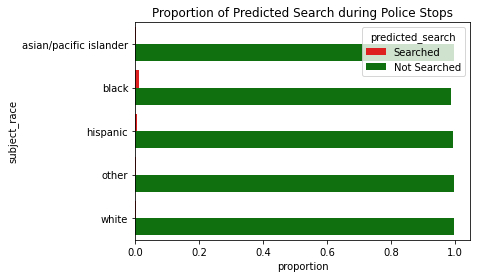

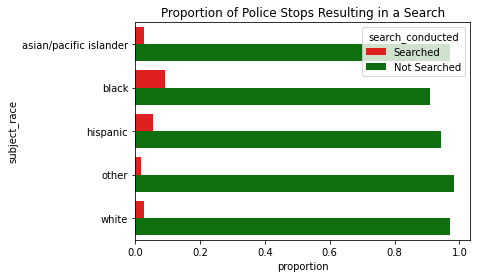

In [10]:
sns.barplot(x='proportion', y='subject_race', hue='predicted_search', data=get_search_probs(df, 'predicted_search'), hue_order=['Searched', 'Not Searched'], palette=['r','g'], orient="h").set_title("Proportion of Predicted Search during Police Stops")
plt.show()
sns.barplot(x='proportion', y='subject_race', hue='search_conducted', data=get_search_probs(df, 'search_conducted'), hue_order=['Searched', 'Not Searched'], palette=['r','g'], orient="h").set_title("Proportion of Police Stops Resulting in a Search")
plt.show()

#  
#  
#  

In [11]:
curr_eval = df[['search_conducted', 'predicted_search', 'contraband_found']]

In [12]:
ps_times = curr_eval.loc[(curr_eval['contraband_found'] == curr_eval['predicted_search']) &
                         (curr_eval['contraband_found'] == True)
                 ].shape[0]

sc_times = curr_eval.loc[(curr_eval['contraband_found'] == curr_eval['search_conducted']) &
                         (curr_eval['contraband_found'] == True)
                 ].shape[0]

print(f"Number of times predicted search yielded contraband: {ps_times}")
print(f"Number of times of search conducted yielded contraband: {sc_times}")

Number of times predicted search yielded contraband: 156
Number of times of search conducted yielded contraband: 1553


In [13]:
ps_times = curr_eval.loc[(curr_eval['contraband_found'] != curr_eval['predicted_search']) &
                         (curr_eval['contraband_found'] == False)
                 ].shape[0]

sc_times = curr_eval.loc[(curr_eval['contraband_found'] != curr_eval['search_conducted']) &
                         (curr_eval['contraband_found'] == False)
                 ].shape[0]

print(f"Number of times predicted search yielded no contraband: {ps_times}")
print(f"Number of times of search conducted yielded no contraband: {sc_times}")

Number of times predicted search yielded no contraband: 1015
Number of times of search conducted yielded no contraband: 14735


# Intersectionality Analysis

> We will see if intersectional categories compound. We can see that the fields subject_sex and is_Black have a high impact on the results, i.e. probability of the algorithm yielding searched==True, given the magnitude of subject_sex[T.male]:is_Black coefficient. It seems that the two fields are correlated.

In [14]:
df['is_Black'] = df['subject_race'].apply(lambda x: 1 if x=='black' else 0)
df['search_conducted'] = df['search_conducted'].apply(lambda x: 1 if x==True else 0)

In [15]:
formula = "predicted_search_prob ~ is_Black + subject_age + subject_sex + subject_sex:is_Black + subject_age:is_Black"
model = smf.ols(formula=formula, data=df).fit()
summary = model.summary()
summary.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0482,0.000,101.448,0.000,0.047,0.049
subject_sex[T.male],0.0087,0.000,27.310,0.000,0.008,0.009
is_Black,0.0193,0.001,13.066,0.000,0.016,0.022
subject_sex[T.male]:is_Black,0.0051,0.001,5.147,0.000,0.003,0.007
subject_age,-0.0004,1.06e-05,-36.068,0.000,-0.000,-0.000
subject_age:is_Black,0.0002,3.37e-05,4.798,0.000,9.58e-05,0.000


> The bar charts below show that bias in the police data does indeed continue in the machine learning algorithm. The algorithm is much more likely to yield a search for Blacks who are below the age of 25 than any other recorded demographic.

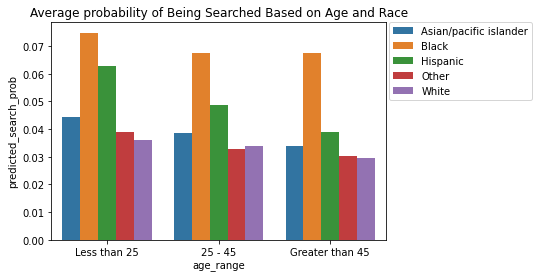

In [16]:
def get_age_range(x):
    if x < 25:
        return "Less than 25"
    elif x >= 25 and x <= 45:
        return "25 - 45"
    elif x > 45:
        return "Greater than 45"
    else:
        return np.NaN

df['age_range'] = df['subject_age'].apply(get_age_range)

def plot_avg_prob(curr_df):

    inter = curr_df[['subject_age', 'subject_sex', 'subject_race', 'predicted_search_prob', 'age_range']]
    inter['subject_race'] = inter['subject_race'].str.capitalize()
    inter=inter.groupby(['age_range', 'subject_race']).mean().reset_index()
    curr_plot = sns.barplot(x='age_range', 
                            y='predicted_search_prob', 
                            hue='subject_race', 
                            data=inter, 
                            order=["Less than 25", "25 - 45", "Greater than 45"]
                           )
    curr_plot.set_title("Average probability of Being Searched Based on Age and Race")

    curr_plot.legend(bbox_to_anchor=(1.01, 1),
                     borderaxespad=0)

    plt.show()
    
plot_avg_prob(df)

> We will continue this analysis only focusing on Whites and Blacks. The ROC curve below shows that the model works best for White females who are less than 25 years old and worst for Black males who are under the age of 25 based on the AUC, i.e. area under the curve. 

In [17]:
from sklearn.metrics import roc_curve, auc, plot_roc_curve, RocCurveDisplay, roc_auc_score
from sklearn.metrics import confusion_matrix

def plot_roc(curr_df):

    f = plt.figure()
    f.set_figwidth(8)
    f.set_figheight(7)

    for race in ['white', 'black']:
        for age in ['Less than 25', '25 - 45', 'Greater than 45']:
            for sex in ['male', 'female']:

                """f_df = df.loc[(df['subject_race']==race) &
                              (df['age_range']==age) &
                              (df['subject_sex']==sex)
                             ][features].apply(enc.fit_transform)"""
                
                l_df = curr_df.loc[(curr_df['subject_race']==race) &
                                   (curr_df['age_range']==age) &
                                   (curr_df['subject_sex']==sex)
                                  ][labels]

                probs = curr_df.loc[(curr_df['subject_race']==race) &
                                    (curr_df['age_range']==age) &
                                    (curr_df['subject_sex']==sex)
                                   ]['predicted_search_prob'].to_numpy()
                #probs = probs[:, 1]  
                fper, tper, thresholds = roc_curve(l_df.to_numpy(), probs) 

                plt.plot(fper, 
                         tper, 
                         label=f'{race.capitalize()} & {age} & {sex}, AUC: {round(auc(fper, tper), 4)}'
                        )


    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Police Search by Race and Age (ROC) Curve')
    plt.legend(bbox_to_anchor=(1.01, 1),
               borderaxespad=0)

    plt.show()

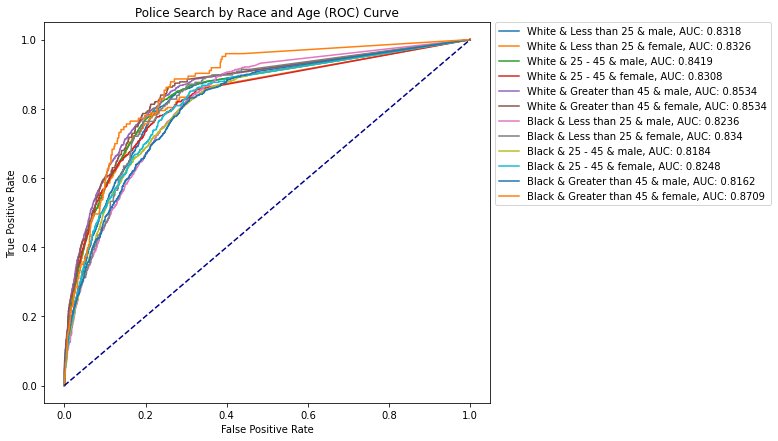

In [18]:
plot_roc(df)

# Using Preprocessing Techniques

> For preprocessing, we will attempt to de-correlate race and age from the probability of someone being searched. We will be using the probabilites assigned to individuals from the algorithm as scores. Assigned probabilities seem to be the best metric for our approach.

> Our appoach will be transforming the probabilities based on their respective quantiles to the median element in the given quantile (across race-age_range combinations).

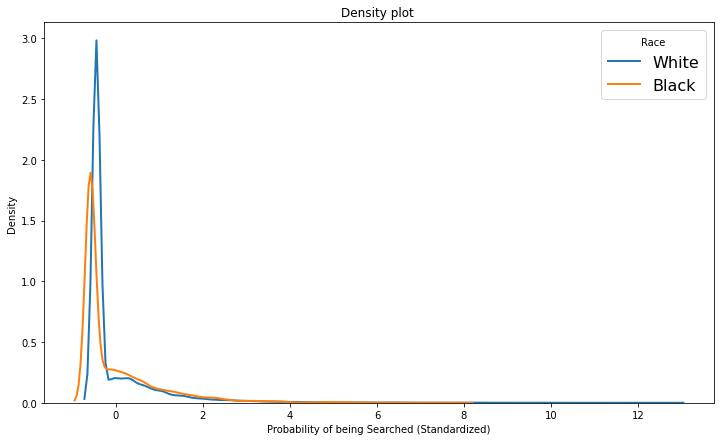

In [19]:
from scipy.stats import norm, probplot
from sklearn import preprocessing

def plot_density(curr_df):
    f = plt.figure()
    f.set_figwidth(12)
    f.set_figheight(7)
    for race in ['white', 'black']:
        curr_data = curr_df[(curr_df['subject_race']==race)]['predicted_search_prob']
        sns.distplot(preprocessing.scale(curr_data), hist = False, kde = True,
                     kde_kws = {'linewidth': 2},
                     label = race.capitalize())

    plt.legend(prop={'size': 16}, title = 'Race')
    plt.title('Density plot ')
    plt.xlabel('Probability of being Searched (Standardized)')
    plt.ylabel('Density')
    plt.show()
    
plot_density(df)

In [20]:
bw = df.loc[(df['subject_race']=='black') | 
            (df['subject_race']=='white')
           ].reset_index()

In [21]:
from scipy import stats
import statistics


races = df.subject_race.unique().tolist()[:-1]
probs_series = {}
for race in ['black', 'white']:
    for age in ['Less than 25', '25 - 45', 'Greater than 45']:
        probs_series[(race, age)] = df[(df['subject_race']==race)&
                                            (df['age_range']==age)
                                           ]['predicted_search_prob'].to_numpy()

def de_correlate(row):
    #print(row['index'])

    try:
        row = row.to_dict()
        prob, race, age_range = row['predicted_search_prob'], row['subject_race'], row['age_range']

        data = probs_series[(race, age_range)]
        curr_percentile = stats.percentileofscore(data, prob)

        percentile_lst = [np.percentile(prob_series, curr_percentile) for prob_series in probs_series.values()]
        
        row['predicted_search_prob'] = statistics.median(percentile_lst)

        return pd.Series(row)
    
    except IndexError as e:
        print(data, curr_percentile)
        return pd.Series(row)
    
    except KeyError as e:
        #print(race)
        return pd.Series(row)

### Before preprocessing

In [22]:
bw.loc[bw['predicted_search_prob'] > 0].iloc[5:10, :][['subject_race', 'age_range', 'predicted_search_prob']]

,subject_race,age_range,predicted_search_prob
17,white,25 - 45,0.109309
27,black,25 - 45,0.192722
28,white,25 - 45,0.119556
29,black,25 - 45,0.161881
30,white,25 - 45,0.091146


### After preprocessing

In [23]:
bw.loc[bw['predicted_search_prob'] > 0].iloc[5:10, :][['subject_race', 'age_range', 'predicted_search_prob']].apply(de_correlate, axis=1)

,subject_race,age_range,predicted_search_prob
17,white,25 - 45,0.165269
27,black,25 - 45,0.146624
28,white,25 - 45,0.178050
29,black,25 - 45,0.122452
30,white,25 - 45,0.141380


In [24]:
import dask.dataframe as dd
import multiprocessing

df_proc = bw.copy()#.reset_index()
ddf = dd.from_pandas(df_proc, npartitions=4*multiprocessing.cpu_count())
ddf = ddf.map_partitions(lambda df: df.apply(de_correlate, axis=1))
df_proc = ddf.compute(scheduler='processes')

# Classifier results after preprocessing

> The results below indicate that the final random forest classifier is more fair than the classifier built from raw police data. Through preprocessing the probabilities, we were able to dramatically improve the classifiers effectiveness for all the groups we're analyzing.

In [25]:
feature_df = bw[features].apply(enc.fit_transform)
feature_df['probs'] = df_proc['predicted_search_prob']
label_df = bw[labels]
x_train, x_test, y_train, y_test = train_test_split(feature_df, label_df, test_size=0.25)

In [26]:
final_model = RandomForestClassifier()
final_model = final_model.fit(x_train, y_train)
f"Score of the Random Forest Classifier: {final_model.score(x_test, y_test)}"

'Score of the Random Forest Classifier: 0.9489391603068335'

In [27]:
predicted_search = pd.Series(final_model.predict(feature_df))
probs = final_model.predict_proba(feature_df)

In [28]:
bw['predicted_search_prob'] = pd.DataFrame(probs)[1]
bw['predicted_search'] = predicted_search

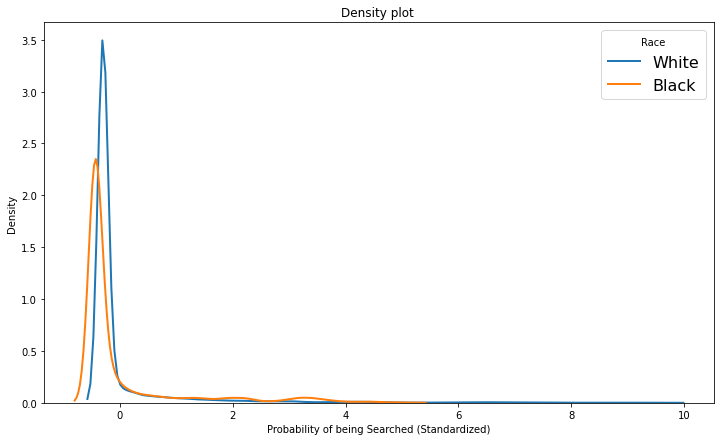

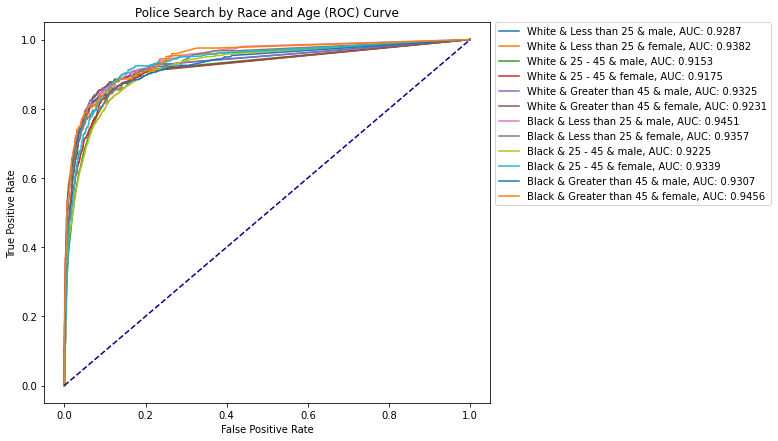

In [29]:
plot_density(bw)
plot_roc(bw)

### Results

> Using preprocessing techniques and creating a new feature seemed to have a strong impact on the effectiveness on classification abilities. 
> There is a notable performance improvement across all groups, in terms of AUC. 

# Conclusion
> Our elaborate feature engineering, i.e. using preprocessing the change the probabilities of being searched and using the result as a new feature, seems to have paid off since the models effectiveness appears to have improved all around.
> While our final algorithm is more fair than what we started with, it still exhibits some intersectional inequalities: 
>  * It performs best on Black & Greater than 45 & female. 
>  * It performs worst on White & 25 - 45 & male

> In practice this double algorithm solution would work through:
>  * Utilizing the fields, 'hour', 'service_area', 'day_of_week', 'month', 'had_info', to yield a probability of whether someone will get searched.
>  * Using preprocessing techniques to better balance the probabilities and reduce intersectional inequalities.
>  * Making final predictions with the aformentioned fields plus the preprocessed probabilities.

>  * To put it briefly, the first ML algorithm uses the fields to yield probabilities, which are preprocessed, then the second ML algorithm uses the preprocessed probabilities plus the fields to predict whether someone will get searched.

> An algorithm like this should not be used in the real world, because a person should not be searched based off of the time of day and where they are. This audit was designed as an experiment to see if raw police stop data can be preprocessed in a way to create a more fair classifier (in terms of our intersectionality analysis). To an extent, it seems to work, however there are other methods we could use, such as threshold tests and feedback loop modeling to audit our results, which may tell a different story. 